# Raster Data Analysis - NDVI, Interpolation, and Clustering 

## Ricardo Antonio Ruiz Cardozo

In [58]:
# import necessary libraries 

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
from rasterio.plot import show
from sklearn.cluster import DBSCAN
from pykrige.ok import OrdinaryKriging

In [18]:
# Download image from OpenAerialMap

url = "https://tiles.openaerialmap.org/5f4960fbce55190005b826b7/5/5f4960fbce55190005b826bd/wmts"
response = requests.get(url)
with open("drone_image.tif", "wb") as f:
    f.write(response.content)

In [23]:
# Step 1: Load raster image (Sentinel-2 or drone) -Desktop
file_path = "Data/drone_image_1.tif"  # Ajustar la ruta según dataset
raster = rasterio.open(file_path)

In [53]:
# Define a smaller region (adjust these values)
x_offset, y_offset = 10000, 10000  # Starting pixel (top-left corner)
width, height = 2000, 2000  # Crop size in pixels

In [54]:
# Read only the cropped window
window = Window(x_offset, y_offset, width, height)
small_raster = raster.read(window=window)

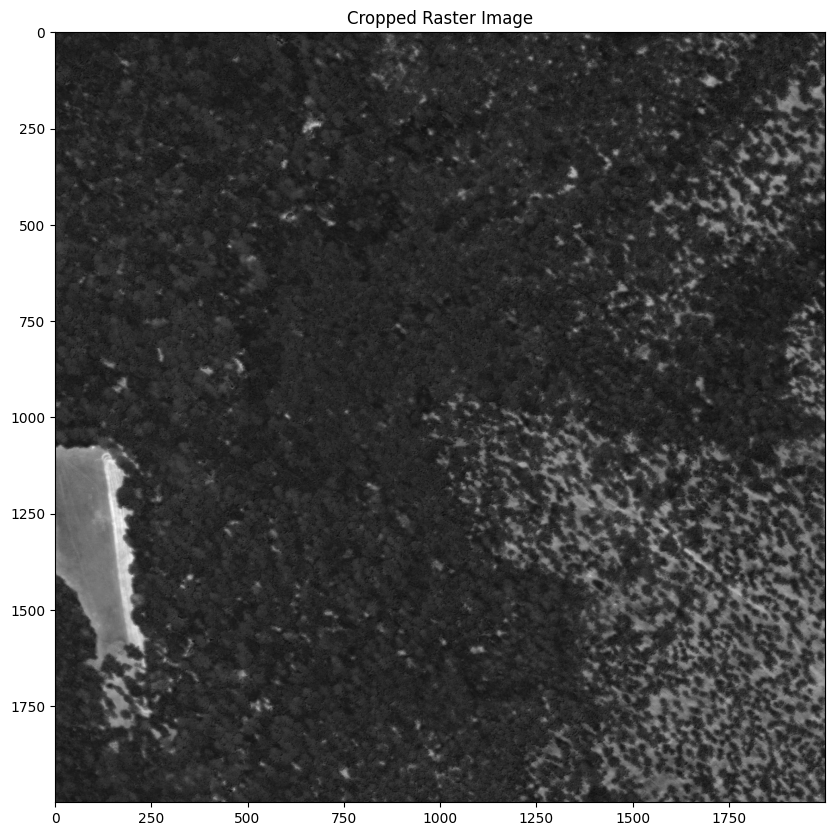

In [55]:
#Plot the cropped image
plt.figure(figsize = (10,10))
plt.imshow(small_raster[0], cmap="gray")
plt.title("Cropped Raster Image")
plt.show()

In [67]:
print(f"Number of bands in the raster: {raster.count}")

Number of bands in the raster: 3


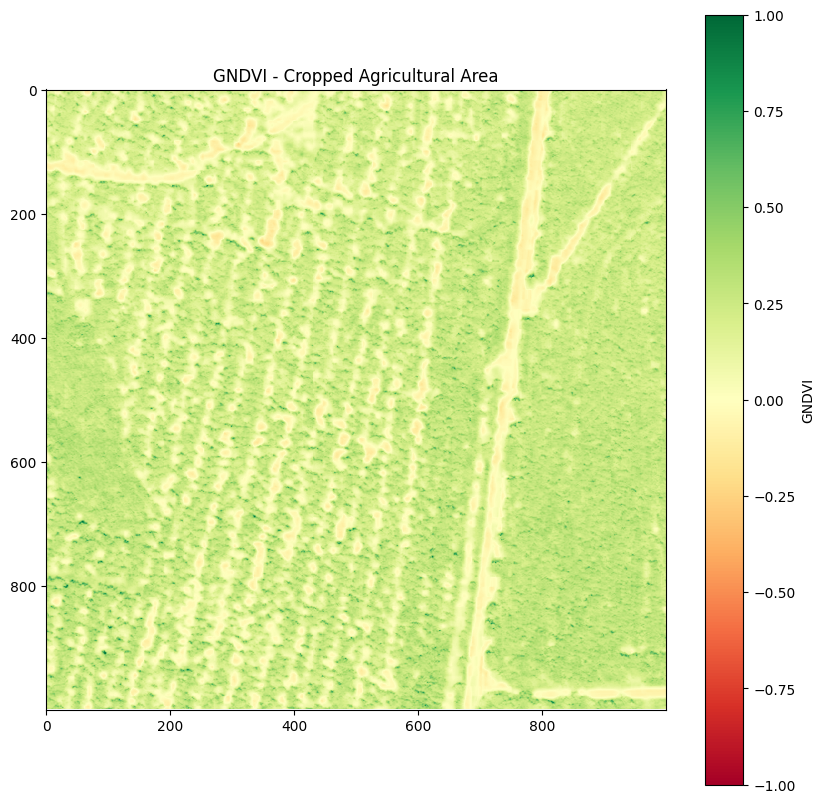

In [73]:
# Step 2: Compute NDVI (NDVI = (NIR - RED) / (NIR + RED)) 
# Approximate NDVI Using the Red and Green Bands

# Get raster dimensions
img_width, img_height = raster.width, raster.height

# Define crop size (adjust as needed)
crop_width, crop_height = 1000, 1000

# Compute central coordinates
x_offset = (img_width - crop_width) // 2
y_offset = (img_height - crop_height) // 2

# Define the crop window
window = Window(x_offset, y_offset, crop_width, crop_height)

# Read Red (Band 1) and Green (Band 2) from the cropped area
red_band = raster.read(1, window=window).astype(float)  
green_band = raster.read(2, window=window).astype(float)

# Compute GNDVI (Green NDVI)
gndvi = (green_band - red_band) / (green_band + red_band)

# Display GNDVI as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(gndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="GNDVI")
plt.title("GNDVI - Cropped Agricultural Area")
#plt.savefig("gndvi_cropped.png")
plt.show()

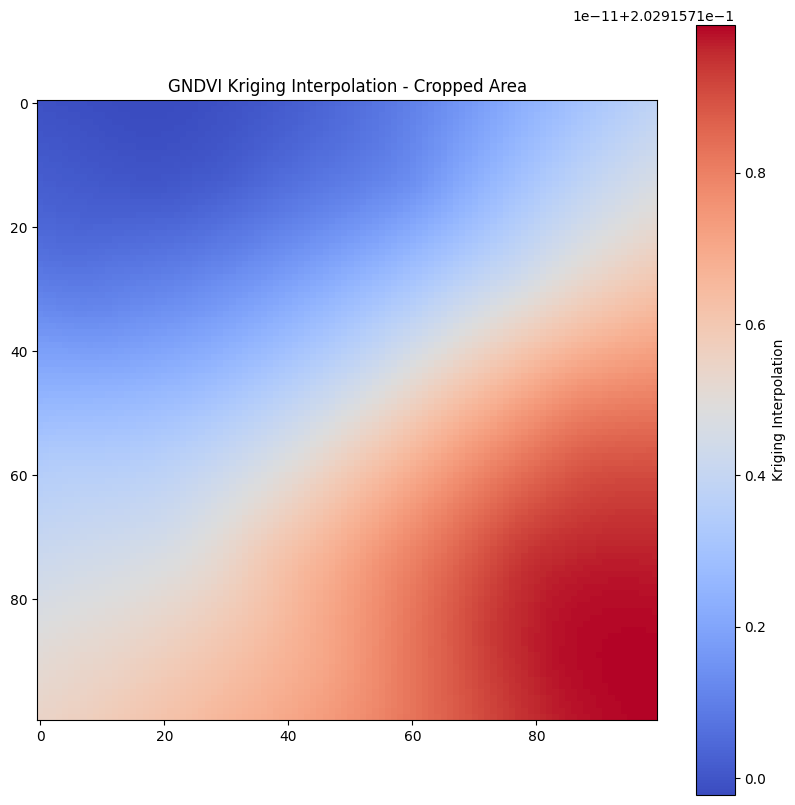

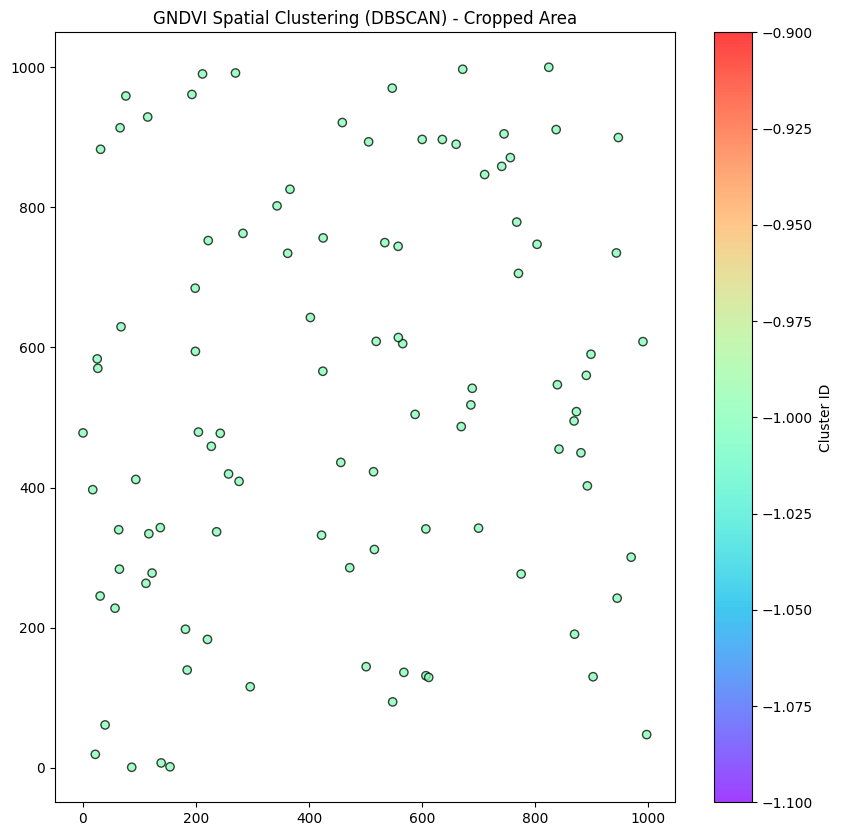

In [74]:
# Apply Kriging Interpolation → Smooth and predict GNDVI across the cropped area.
# Apply DBSCAN Clustering → Detect spatial patterns in vegetation.
# Generate Visualizations → Save heatmaps and clustered maps.

# Step 1: Generate Sample Points from GNDVI
gridx = np.linspace(0, gndvi.shape[1], 100)
gridy = np.linspace(0, gndvi.shape[0], 100)

x = np.random.rand(100) * gndvi.shape[1]  # Random sample points
y = np.random.rand(100) * gndvi.shape[0]
z = gndvi[y.astype(int), x.astype(int)]

# Step 2: Apply Kriging Interpolation
OK = OrdinaryKriging(x, y, z, variogram_model="linear", verbose=False, enable_plotting=False)
z_kriged, ss = OK.execute("grid", gridx, gridy)

# Display Kriging Interpolation
plt.figure(figsize=(10, 10))
plt.imshow(z_kriged, cmap="coolwarm")
plt.colorbar(label="Kriging Interpolation")
plt.title("GNDVI Kriging Interpolation - Cropped Area")
plt.savefig("gndvi_kriging.png")
plt.show()

# Step 3: Apply DBSCAN Clustering
coords = np.column_stack((x, y))
db = DBSCAN(eps=50, min_samples=5).fit(coords)
labels = db.labels_

# Display Clustering Results
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=labels, cmap="rainbow", edgecolor="k", alpha=0.75)
plt.title("GNDVI Spatial Clustering (DBSCAN) - Cropped Area")
plt.colorbar(label="Cluster ID")
plt.savefig("gndvi_clustering.png")
plt.show()
